# Image regeneration using VAE 

In this exercise we will create VAE encoder decoder network to compress the image and them regenerate the image from the compressed state.
We will use the **Mint dataset** — a small image dataset.

### **Stages**

1. **Import Necessary Libraries** – Load required Python and deep learning packages.  
2. **Download and Load the MNIST Dataset** – Explore its structure and format.  
3. **Preprocess and Prepare DataLoaders** – Normalize, resize, and split the dataset into training, validation, and test sets. 
5. **Define and Train Models** – Implement the VAE network. 
Complete the code blocks marked with:

```python
YOUR ANSWER HERE

## 1. Import Necessary Libraries

In this section, we import the essential Python libraries required for building, training, and evaluating our convolutional residual networks.

We will use:
- **PyTorch** for model definition, training, and evaluation.  
- **Torchvision** for loading and transforming the MNIST dataset. 
- **Seaborn and matplotlib** for image visualization and dataset exploring. 
- **NumPy** for numerical operations.  
- **Random** for setting the random seed. 
- **tqdm** for tracking training progress.

Make sure all required packages are installed before proceeding.

In [ ]:
import asyncio
asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
import numpy as np
import seaborn as sns

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary

from torchvision import datasets 
import torchvision.transforms as tfs

from tqdm.auto import tqdm

from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import random

import numpy as np

torch.cuda.manual_seed_all(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/opt/homebrew/anaconda3/envs/dl_course/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Download, Load and preprocess the MNIST Dataset 

In this section, we will download the **MNIST** dataset, which contains **60,000 training** and **10,000 test** grayscale images of handwritten digits (0–9), each of size **28×28 pixels**.

We will:
- Use `torchvision.datasets.MNIST` to download and load the data.  
- Apply image transformations such as **tensor conversion** and **normalization** to ensure consistent model training.  
- Create **DataLoaders** for both training and testing sets, enabling efficient mini-batch processing.

### Normalization Details
The images are normalized using the mean and standard deviation of the MNIST dataset:
- Mean = 0.1307  
- Std  = 0.3081

In [7]:
transform = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 7.34MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 188kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 564kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 926kB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [9]:
print(len(train_loader.dataset.data) , len(train_loader.dataset.targets) , len(test_loader.dataset.data) , len(test_loader.dataset.targets))
classes = train_dataset.classes
classes

60000 60000 10000 10000


['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

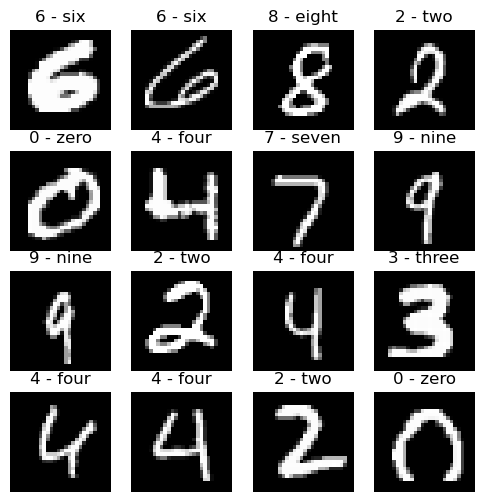

In [10]:
fig = plt.figure(figsize=(6,6))
rows,cols = 4,4

for i in range(1,cols*rows+1):
    random_idx = torch.randint(0,len(train_loader.dataset),size=[1]).item()
    img,label = train_loader.dataset[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(classes[label])
    plt.axis(False);

# 4. Model Definition and Training
In this section we will define and test the Variational Autoencoder block. Implement the model according to the given instructions.

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self,z_dim=2):
        super().__init__()
        self.encoder = None
        self.fc_mu = None
        self.fc_var = None
        ''' 
        TODO: Define the encoder part of the VAE according to the architecture described.
        use nn.Sequential to stack the layers.
        The encoder should consist of:
        - Conv2d layer with 32 filters, kernel size 3, padding 1, followed by BatchNorm2d and ReLU activation
        - Conv2d layer with 64 filters, kernel size 3, padding 1, stride 2, followed by BatchNorm2d and ReLU activation
        - Conv2d layer with 64 filters, kernel size 3, padding 1, stride 2, followed by BatchNorm2d and ReLU activation
        - finally followed by nn.Flatten() layer to flatten the output.
        After the encoder, define two fully connected layers (self.fc_mu and self.fc_var) to map the output of the encoder to the mean and log variance of the latent space.
        The input to these layers should be of size 64*7*7 (the output size of the encoder) and the output size should be z_dim.
        '''
        # YOUR CODE HERE
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64*7*7, z_dim)
        self.fc_var = nn.Linear(64*7*7, z_dim)

        self.decoder = None
        '''
        Todo: Define the decoder part of the VAE according to the architecture described.
        use nn.Sequential to stack the layers.
        The decoder should consist of:
        - A fully connected layer that maps from z_dim to 64*7*7
        - Unflatten layer to reshape the output to (64,7,7)
        - ConvTranspose2d layer with 64 filters, kernel size 3, padding 1, output padding 1, stride 2, followed by BatchNorm2d and ReLU activation
        - ConvTranspose2d layer with 32 filters, kernel size 3, padding 1, output padding 1, stride 2, followed by BatchNorm2d and ReLU activation
        - A final ConvTranspose2d layer with 1 filter, kernel size 3, padding 1, followed by Sigmoid activation to output the reconstructed image.
        '''

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64*7*7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        self.latent = torch.empty(z_dim)
        self.mu = None
        self.log_var = None
    
    def forward(self,x):
        
        '''
        TODO: Implement the forward pass of the VAE.
        - Pass the input x through the encoder to get the encoded representation.
        - Compute the mean (self.mu) and log variance (self.sigma) of the latent space.
        - Sample from the latent space using the reparameterization trick: z = mu + sigma * eps, where eps is sampled from a standard normal distribution.
        - Pass the sampled latent vector z through the decoder to get the reconstructed output.
        - Store the sampled latent vector in self.latent for later use.
        - Return the reconstructed output.

        '''

        encoded = self.encoder(x)
        self.mu = self.fc_mu(encoded)
        self.sigma = self.fc_var(encoded)
        sigma = torch.exp(0.5 * self.sigma)
        eps = torch.randn_like(sigma)
        z = self.mu + sigma * eps
        self.latent = z
        decoded = self.decoder(z)

        return decoded

In [16]:
ae = AutoEncoder().to(DEVICE)
torchsummary.summary(ae, input_size=(1, 28, 28), device=str(DEVICE))
del ae

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
       BatchNorm2d-5           [-1, 64, 14, 14]             128
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
       BatchNorm2d-8             [-1, 64, 7, 7]             128
              ReLU-9             [-1, 64, 7, 7]               0
          Flatten-10                 [-1, 3136]               0
           Linear-11                    [-1, 2]           6,274
           Linear-12                    [-1, 2]           6,274
           Linear-13                 [-1, 3136]           9,408
        Unflatten-14             [-1, 6

In [19]:
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,mu: torch.Tensor, logsigma: torch.Tensor):
        '''
        TODO: Implement the KL Divergence loss between the learned latent distribution and the standard normal distribution.
        The formula for KL Divergence in this case is:
        KL(N(mu, sigma) || N(0, 1)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        the logsigma parameter represents log(sigma^2)
        '''
        # YOUR CODE HERE
        Kl = -0.5 * torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma))
        return Kl

class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl_divergence = KLDivergenceLoss()
        self.log_likelihood = nn.MSELoss()
    
    def forward(self,mu,logsigma,outputs,labels):
        return self.kl_divergence(mu,logsigma)+self.log_likelihood(outputs,labels)

In [20]:
model = AutoEncoder(z_dim=2).to(DEVICE)

EPOCHS = 4
criterion = VAELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)


train_losses = []
test_losses = []

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}")
    
    trainloss = 0
    acc_epoch = 0
    for batch,(X,y) in enumerate(train_loader):
        model.train()
        X=X.to(DEVICE)
        y_pred = model(X).to(DEVICE)
        mu,logsigma = model.mu,model.sigma
        
        
        loss = criterion(mu,logsigma,y_pred,X.float())
        loss_ = loss.detach().cpu().item()
        trainloss += loss_
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

   
    trainloss /=len(train_loader)
    train_losses.append(trainloss)
    
    testloss = 0
    model.eval()
    
    with torch.inference_mode():
        for X,y in test_loader:
            X = X.to(DEVICE)
            test_pred=model(X).to(DEVICE)
            mu_test,logsigma_test = model.mu,model.sigma
            loss = criterion(mu,logsigma,test_pred,X.float())
            loss_test_ = loss.detach().cpu().item()
            testloss+=loss_test_
        testloss /= len(test_loader)  
    
    test_losses.append(testloss)
    
    print(f"\nTrain loss: {trainloss:.5f} | Test loss: {testloss:.5f}")


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0


 25%|██▌       | 1/4 [01:43<05:10, 103.35s/it]


Train loss: 1.06495 | Test loss: 0.92615
Epoch: 1


 50%|█████     | 2/4 [03:25<03:25, 102.64s/it]


Train loss: 0.86217 | Test loss: 0.86199
Epoch: 2


 75%|███████▌  | 3/4 [05:06<01:41, 101.85s/it]


Train loss: 0.83816 | Test loss: 0.82684
Epoch: 3


100%|██████████| 4/4 [06:51<00:00, 102.96s/it]


Train loss: 0.81990 | Test loss: 0.83792


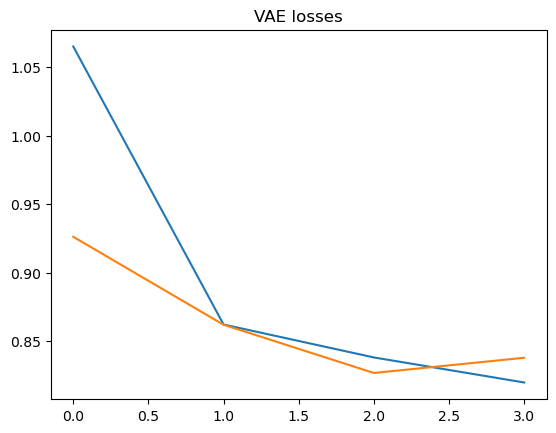

In [21]:
plt.title('VAE losses')
sns.lineplot(x=range(len(train_losses)), y=train_losses)
sns.lineplot(x=range(len(test_losses)), y=test_losses)
plt.show()

In [ ]:
# This cell contains hidden test cases that will be evaluated after submission

In [ ]:
# This cell contains hidden test cases that will be evaluated after submission